In [4]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from collections import Counter

DIVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATCH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATCH / 'morse_dataset'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 15
TIME_MASK = 20

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 32
EPOCHS = 70
LEARNING_RATE = 0.002 #2e-4
WEIGHT_DECAY = 0.00001
# int_to_alph = dict(enumerate(MORSEALP))
# alph_to_int = {char:enum for enum, char in int_to_alph.items()}

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'sample_submission.csv'))

all_chars = Counter("".join(train_data['message']))
BLANK_CHAR = "_"
vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
num_classes = len(vocab_list)
char_to_int = {char: i for i, char in enumerate(vocab_list)}
int_to_char = {i: char for i, char in enumerate(vocab_list)}
BLANK_IDX = char_to_int[BLANK_CHAR]

class MosreDataset(Dataset):
    """
    Класс для обработки 
    """
    def __init__(self, df, data_patch,char_to_int, train=True, transforms=None, prev_chars = 1):
        self.df = df
        self.is_train = train

        self.data_path = data_patch
        self.audio_paths = self.data_path / 'morse_dataset'

        self.transforms = transforms

        self.char_to_int = char_to_int
        self.prev_chars = prev_chars

        if self.is_train:
            self.messeges = self.df.message.values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #Получение аугментрованых спектрограмм
        try:
            audio_file = self.audio_paths / self.df.id.values[index]
            waveform, sample_rate = torchaudio.load(audio_file)
            augmented_spectrogram = self.transforms(waveform)

            if self.is_train:
                message = self.messeges[index]
                #Получение списка индексов секта - как требует CTC los
                '''
                При обработке dataloader labels будут выравниваться по макс длине для выравнивания батча
                Т.е. будет padding 0. что в будующем будет пустым значением для ctc loss
                '''
                target = torch.tensor([self.char_to_int[char] for char in message], dtype=torch.long); 
                target_len = torch.tensor(len(target), dtype=torch.long)
                return augmented_spectrogram, target, target_len, message
            else:
                return augmented_spectrogram, None, None, None
        except Exception as ex:
            print(str(ex))
        
    def change_time(self, audio_file, max_len = 384000):
        waveform, sample_rate = torchaudio.load(audio_file)
        cahanal, sig_len = waveform.shape

        if sig_len < max_len:
            pad_len = torch.zeros(max_len - sig_len).unsqueeze(0)
            waveform = torch.cat([waveform, pad_len], dim=1)

        return waveform
    
FIRST_FE_COUNT = 16
SECOND_FE_COUNT = 32
THIRD_FE_COUNT = 32
QAD_FE_COUNT = 32
PADDING = 'same'
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 256
# Start with 4 transforms
class MorseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((1, 2), (1, 2)), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 2), (2, 2)), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)) # [batch=32, QAD_FE_COUNT = 32, 8, 80](что юы сохраниить большще признаков по горизонтали)
        )
        with torch.no_grad(): 
            dummy_input = torch.randn(1, 1, N_MELS, 356); 
            cnn_out = self.net_conv(dummy_input); 
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]

        print(f"CNN размерность выхода: {cnn_out.shape}"); 
        print(f"CNN число фичей: {self.cnn_output_features}")

        # Добавлен лоейный слой и функция активации. Для чего? расписать потом 
        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2); 
        self.gelu = nn.GELU()
        print(f"Проекция из {self.cnn_output_features} в {GRU_HIDEN*2}")
        self.rnn = nn.LSTM(
                input_size=N_MELS*2,
                hidden_size=GRU_HIDEN,
                num_layers=2,
                bidirectional=True,
                dropout=0.3,
                batch_first=True 
            )

        
        self.embed_dim = GRU_HIDEN * 2
        self.layer_norm = nn.LayerNorm(self.embed_dim)      
        self.dropout = nn.Dropout(0.3)   
        self.layer2 = nn.Linear(self.embed_dim, num_classes)       
        # self.layer3 = nn.Linear(GRU_HIDEN, GRU_HIDEN // 2)       
        # self.layer4 = nn.Linear(GRU_HIDEN // 2, 45)             

    def forward(self, x):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]

        # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # собой объединение столбцов всех карт. 
        # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=32, seq_len=89, features/hiden_dim=512]
        x = self.layer1(x)
        x = self.gelu(x)

        self.rnn.flatten_parameters()

        x = self.rnn(x) # [batch=32, seq_len=89, features/hiden_dim=256 * 2]
        x, _ = x # берем информацию со всез состояний
        x = self.layer_norm(x)
        x = self.dropout(x)
        x = self.layer2(x) # logits - [batch, sequence, num_classes] 
        x = nn.functional.log_softmax(x.permute(1,0,2), dim=2) # pertime так как CTC loss требует на взод (sequence/T,batch/N,num_classes/C)
        '''
        по одному прогнозу для каждого из признаков в последовательности, 
        в итоге получается 89 прогнозов символов для каждой секунды звука.
        '''
        return x
    

train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK),
    transforms.TimeMasking(time_mask_param=TIME_MASK),
    # v2.RandomCrop((N_MELS, 1920)) # Обрезает последний кадр спектрограммы, в идеале надобы считать а не прописывать число
    ) # заметка - Данные трансформации не создают довых обучаемых параметров. Но есть и те что создают. В будущем это стоит учитывать

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    # v2.CenterCrop((N_MELS, 1920)) 
    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.15, random_state=SEED)

train_ds = MosreDataset(df=train_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=train_audio_transforms)

val_ds = MosreDataset(df=val_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=valid_audio_transforms)


def my_collate(batch):
    spectrograms = [item[0].squeeze(0) for item in batch]
    # Падинг спектрограмм по максимальной длине
    spectrograms_permuted = [s.permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)

    if batch[0][3] is not None:
        target = torch.nn.utils.rnn.pad_sequence(
                                                [item[1] for item in batch], 
                                                batch_first=True, 
                                                padding_value=BLANK_IDX)# выравнивает последовательность до макс 
                                                                        # длины в батче заполняя пропуски нулем
        label_len = torch.stack([item[2] for item in batch])
        msg = [item[3] for item in batch]
        
        return [spectrograms_padded, target, label_len, msg]
    else: 
        return spectrograms_padded

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)

test, test_target, _, mess = next(iter(train_dl))
test, test_target= test.to(DIVICE), test_target.to(DIVICE)

test_val, val_target, __, val_mess = next(iter(val_dl))
test_val, val_target = test_val.to(DIVICE), val_target.to(DIVICE)
# test.shape 

#===== начало обучения =====
model = MorseNet(num_classes=num_classes).to(DIVICE)
# model = DataParallel(model)
optimizer = optim.Adam(params=model.parameters(), lr=0.002)  # Было 0.002
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
loss_func = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(DIVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMorseNet - инициалицация модели. Число обучаемых параметров: {total_params:,}")

CNN размерность выхода: torch.Size([1, 32, 16, 89])
CNN число фичей: 512
Проекция из 512 в 512

MorseNet - инициалицация модели. Число обучаемых параметров: 2,808,589


# Обучение модели

In [2]:
import Levenshtein
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds


In [2]:
lst_loss_train = []
lst_loss_val = []
best_val_loss = 0
for epoch in range(EPOCHS):
    model.train()

    epoch_train_loss = 0.0
    train_predicts = []

    train_tqdm = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for batch_ind, batch in enumerate(train_tqdm):
        mel_spec, targets, targets_lens, _ = batch
        mel_spec, targets, targets_lens = mel_spec.to(DIVICE), targets.to(DIVICE), targets_lens.to(DIVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====
        
        optimizer.zero_grad()
        predict = model(mel_spec) # (N=batch,T,C)
        N = predict.shape[1]
        T = predict.shape[0]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

    #     print("Predict shape:", predict.shape) # [T, N, C]
    #     print("Labels shape:", targets.shape)   # [N, max_label_len]
    #     print("Predict lengths:", predict_lengths) # [N]
    #     print("Target lengths:", targets_lens.reshape(BATCH_SIZE))   # [N]
    #     break
    # break
        try:
            loss = loss_func(predict, targets, predict_lengths, targets_lens.reshape(BATCH_SIZE))
        except RuntimeError:
            print(predict.shape, targets.shape, predict_lengths, targets_lens.reshape(BATCH_SIZE))
            continue
        # print(loss)
        if torch.isnan(loss) or torch.isinf(loss): 
            print(f"\nWarning: In batch-{batch_ind} loss train is NaN/Inf: {loss.item()}"); 
            optimizer.zero_grad(); 
            continue

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()

    train_loss = epoch_train_loss / len(train_dl)

    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    total_val = 0
    val_predicts = []

    with torch.no_grad():
        for val_mel_spec, val_labels, val_label_lensin, _ in tqdm(
                                                        val_dl, 
                                                        desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", 
                                                        leave=False):
            val_mel_spec, val_labels, val_label_lensin = val_mel_spec.to(DIVICE), val_labels.to(DIVICE), val_label_lensin.to(DIVICE)
            val_predict = model(val_mel_spec)

            val_N = val_predict.shape[1]
            val_T = val_predict.shape[0]
            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            val_loss += loss_func(val_predict, val_labels, predict_val_lengths, val_label_lensin).item()

    total_val = val_loss / len(val_dl)

    lst_loss_train.append(train_loss)
    lst_loss_val.append(total_val)

    scheduler.step(total_val)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Новая лучшая модель сохранена с val_loss: {val_loss:.4f}")
    

    print(f"\n===== Эпоха {epoch+1}/{EPOCHS} =====")\
    #===== Инфо про градиенты=====
    grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    if grad_norms:
        print(f"Mean grad norm: {np.mean(grad_norms):.6f}")
        print(f"Max grad norm: {np.max(grad_norms):.6f}")
        print(f"Min grad norm: {np.min(grad_norms):.6f}")
    else:
        print("No gradients computed yet.")
    #===== Инфо про шаг обучения и данные по потерям =====
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.6f}")
    print(f"---- Train Loss: {train_loss:.4f}")
    print(f"---- Val Loss: {total_val:.4f}")
    if current_lr <= 1e-6:
        print("Learning rate достиг минимума 1e-6, остановка обучения")
        break
    print("-" * 50)


===== Эпоха 1/70 =====
Mean grad norm: 0.023675
Max grad norm: 0.734516
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.1222
---- Val Loss: 4.0273
--------------------------------------------------



===== Эпоха 2/70 =====
Mean grad norm: 0.025047
Max grad norm: 0.688410
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.0209
---- Val Loss: 4.0110
--------------------------------------------------



===== Эпоха 3/70 =====
Mean grad norm: 0.044003
Max grad norm: 0.767650
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.0013
---- Val Loss: 4.0116
--------------------------------------------------



===== Эпоха 4/70 =====
Mean grad norm: 0.042930
Max grad norm: 0.555077
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 3.9749
---- Val Loss: 4.0334
--------------------------------------------------



===== Эпоха 5/70 =====
Mean grad norm: 0.094253
Max grad norm: 0.758000
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 2.1378
---- Val Loss: 0.5695
--------------------------------------------------



===== Эпоха 6/70 =====
Mean grad norm: 0.091575
Max grad norm: 0.465354
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.7556
---- Val Loss: 0.3405
--------------------------------------------------



===== Эпоха 7/70 =====
Mean grad norm: 0.083576
Max grad norm: 0.845196
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.5862
---- Val Loss: 0.2929
--------------------------------------------------



===== Эпоха 8/70 =====
Mean grad norm: 0.080779
Max grad norm: 0.553523
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.5125
---- Val Loss: 0.2640
--------------------------------------------------



===== Эпоха 9/70 =====
Mean grad norm: 0.094130
Max grad norm: 0.400904
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.4609
---- Val Loss: 0.2280
--------------------------------------------------



===== Эпоха 10/70 =====
Mean grad norm: 0.063396
Max grad norm: 0.291099
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.4324
---- Val Loss: 0.2276
--------------------------------------------------



===== Эпоха 11/70 =====
Mean grad norm: 0.100314
Max grad norm: 0.689743
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.4059
---- Val Loss: 0.2587
--------------------------------------------------



===== Эпоха 12/70 =====
Mean grad norm: 0.066257
Max grad norm: 0.415017
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3917
---- Val Loss: 0.1945
--------------------------------------------------



===== Эпоха 13/70 =====
Mean grad norm: 0.093376
Max grad norm: 0.480987
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3768
---- Val Loss: 0.1985
--------------------------------------------------



===== Эпоха 14/70 =====
Mean grad norm: 0.100119
Max grad norm: 0.699742
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3663
---- Val Loss: 0.1859
--------------------------------------------------



===== Эпоха 15/70 =====
Mean grad norm: 0.067964
Max grad norm: 0.273582
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3589
---- Val Loss: 0.1802
--------------------------------------------------



===== Эпоха 16/70 =====
Mean grad norm: 0.102547
Max grad norm: 0.616991
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3452
---- Val Loss: 0.1763
--------------------------------------------------



===== Эпоха 17/70 =====
Mean grad norm: 0.063354
Max grad norm: 0.324068
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3377
---- Val Loss: 0.1841
--------------------------------------------------



===== Эпоха 18/70 =====
Mean grad norm: 0.113041
Max grad norm: 0.533269
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3299
---- Val Loss: 0.1828
--------------------------------------------------



===== Эпоха 19/70 =====
Mean grad norm: 0.103012
Max grad norm: 0.710960
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3269
---- Val Loss: 0.1651
--------------------------------------------------



===== Эпоха 20/70 =====
Mean grad norm: 0.104565
Max grad norm: 0.552992
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3194
---- Val Loss: 0.1563
--------------------------------------------------



===== Эпоха 21/70 =====
Mean grad norm: 0.111411
Max grad norm: 0.456038
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3046
---- Val Loss: 0.1527
--------------------------------------------------



===== Эпоха 22/70 =====
Mean grad norm: 0.053960
Max grad norm: 0.253663
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3099
---- Val Loss: 0.1693
--------------------------------------------------



===== Эпоха 23/70 =====
Mean grad norm: 0.088423
Max grad norm: 0.632960
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.3004
---- Val Loss: 0.1731
--------------------------------------------------



===== Эпоха 24/70 =====
Mean grad norm: 0.039369
Max grad norm: 0.137050
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2904
---- Val Loss: 0.1511
--------------------------------------------------



===== Эпоха 25/70 =====
Mean grad norm: 0.056855
Max grad norm: 0.234517
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2821
---- Val Loss: 0.1469
--------------------------------------------------



===== Эпоха 26/70 =====
Mean grad norm: 0.099585
Max grad norm: 0.406696
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2742
---- Val Loss: 0.1477
--------------------------------------------------



===== Эпоха 27/70 =====
Mean grad norm: 0.065297
Max grad norm: 0.382135
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2732
---- Val Loss: 0.1526
--------------------------------------------------



===== Эпоха 28/70 =====
Mean grad norm: 0.068043
Max grad norm: 0.327657
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 0.2620
---- Val Loss: 0.1539
--------------------------------------------------



===== Эпоха 29/70 =====
Mean grad norm: 0.059419
Max grad norm: 0.392717
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2607
---- Val Loss: 0.1547
--------------------------------------------------



===== Эпоха 30/70 =====
Mean grad norm: 0.082096
Max grad norm: 0.508613
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2396
---- Val Loss: 0.1351
--------------------------------------------------



===== Эпоха 31/70 =====
Mean grad norm: 0.055707
Max grad norm: 0.290325
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2272
---- Val Loss: 0.1422
--------------------------------------------------



===== Эпоха 32/70 =====
Mean grad norm: 0.073551
Max grad norm: 0.398146
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2237
---- Val Loss: 0.1371
--------------------------------------------------



===== Эпоха 33/70 =====
Mean grad norm: 0.044252
Max grad norm: 0.261727
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2162
---- Val Loss: 0.1449
--------------------------------------------------



===== Эпоха 34/70 =====
Mean grad norm: 0.034773
Max grad norm: 0.155621
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.2159
---- Val Loss: 0.1364
--------------------------------------------------



===== Эпоха 35/70 =====
Mean grad norm: 0.036047
Max grad norm: 0.161007
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.2045
---- Val Loss: 0.1416
--------------------------------------------------



===== Эпоха 36/70 =====
Mean grad norm: 0.055027
Max grad norm: 0.323920
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1997
---- Val Loss: 0.1403
--------------------------------------------------



===== Эпоха 37/70 =====
Mean grad norm: 0.100560
Max grad norm: 0.628666
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1963
---- Val Loss: 0.1407
--------------------------------------------------



===== Эпоха 38/70 =====
Mean grad norm: 0.114679
Max grad norm: 0.459898
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1965
---- Val Loss: 0.1391
--------------------------------------------------



===== Эпоха 39/70 =====
Mean grad norm: 0.052316
Max grad norm: 0.280666
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1891
---- Val Loss: 0.1407
--------------------------------------------------



===== Эпоха 40/70 =====
Mean grad norm: 0.051712
Max grad norm: 0.273996
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1856
---- Val Loss: 0.1400
--------------------------------------------------



===== Эпоха 41/70 =====
Mean grad norm: 0.095474
Max grad norm: 0.610184
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1860
---- Val Loss: 0.1410
--------------------------------------------------



===== Эпоха 42/70 =====
Mean grad norm: 0.049080
Max grad norm: 0.240725
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1842
---- Val Loss: 0.1402
--------------------------------------------------



===== Эпоха 43/70 =====
Mean grad norm: 0.071425
Max grad norm: 0.341813
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1796
---- Val Loss: 0.1417
--------------------------------------------------



===== Эпоха 44/70 =====
Mean grad norm: 0.056629
Max grad norm: 0.385452
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1775
---- Val Loss: 0.1409
--------------------------------------------------



===== Эпоха 45/70 =====
Mean grad norm: 0.045382
Max grad norm: 0.280828
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1774
---- Val Loss: 0.1416
--------------------------------------------------



===== Эпоха 46/70 =====
Mean grad norm: 0.041747
Max grad norm: 0.169365
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 0.1788
---- Val Loss: 0.1456
--------------------------------------------------



===== Эпоха 47/70 =====
Mean grad norm: 0.063846
Max grad norm: 0.308806
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 0.1764
---- Val Loss: 0.1427
--------------------------------------------------



===== Эпоха 48/70 =====
Mean grad norm: 0.040220
Max grad norm: 0.176586
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 0.1756
---- Val Loss: 0.1433
--------------------------------------------------



===== Эпоха 49/70 =====
Mean grad norm: 0.040122
Max grad norm: 0.199680
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 0.1734
---- Val Loss: 0.1441
--------------------------------------------------



===== Эпоха 50/70 =====
Mean grad norm: 0.044917
Max grad norm: 0.237614
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 0.1743
---- Val Loss: 0.1440
--------------------------------------------------



===== Эпоха 51/70 =====
Mean grad norm: 0.059349
Max grad norm: 0.297782
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 0.1735
---- Val Loss: 0.1442
--------------------------------------------------



===== Эпоха 52/70 =====
Mean grad norm: 0.065853
Max grad norm: 0.323859
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 0.1759
---- Val Loss: 0.1440
--------------------------------------------------



===== Эпоха 53/70 =====
Mean grad norm: 0.080306
Max grad norm: 0.445562
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 0.1704
---- Val Loss: 0.1458
--------------------------------------------------



===== Эпоха 54/70 =====
Mean grad norm: 0.095591
Max grad norm: 0.724328
Min grad norm: 0.000000
Current LR: 0.000016
---- Train Loss: 0.1755
---- Val Loss: 0.1435
--------------------------------------------------



===== Эпоха 55/70 =====
Mean grad norm: 0.108141
Max grad norm: 0.461031
Min grad norm: 0.000000
Current LR: 0.000016
---- Train Loss: 0.1732
---- Val Loss: 0.1453
--------------------------------------------------



===== Эпоха 56/70 =====
Mean grad norm: 0.038870
Max grad norm: 0.184287
Min grad norm: 0.000000
Current LR: 0.000016
---- Train Loss: 0.1699
---- Val Loss: 0.1448
--------------------------------------------------



===== Эпоха 57/70 =====
Mean grad norm: 0.106196
Max grad norm: 0.474125
Min grad norm: 0.000000
Current LR: 0.000016
---- Train Loss: 0.1723
---- Val Loss: 0.1454
--------------------------------------------------



===== Эпоха 58/70 =====
Mean grad norm: 0.045327
Max grad norm: 0.178904
Min grad norm: 0.000000
Current LR: 0.000008
---- Train Loss: 0.1721
---- Val Loss: 0.1441
--------------------------------------------------


KeyboardInterrupt: 

In [3]:
torch.save(model.state_dict(), 'MorseNet.pth')

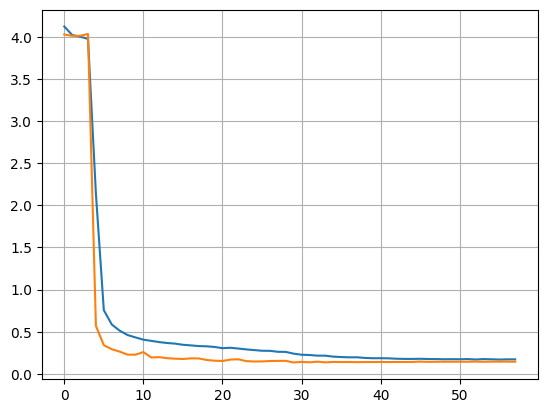

In [4]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()

In [ ]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu()
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy()

    for ind in max_inds:
        merged_inds = []
        prev_idx = None
        for idx in ind:
            if idx != blank_label_idx and idx != prev_idx:
                merged_inds.append(idx)
            prev_idx = idx
        text = "".join([int_char_map.get(i, '') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes)
model_load.load_state_dict(torch.load('MorseNet_№1.pth'))
model_load.eval()

with torch.no_grad():
    train_mess = []
    train_predicts = []
    for loader in train_dl:
        seq, test_target, _, mess = loader
        train_mess.extend(mess)

        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        train_predicts.extend(predicted_values)

    val_mess = []
    val_predicts = []
    for loader in val_dl:
        seq, test_target, _, mess = loader
        val_mess.extend(mess)

        logits= model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        val_predicts.extend(predicted_values)

import Levenshtein

mean_acc_test = np.mean([Levenshtein.ratio(test_pred, train_mess[ind]) for ind, test_pred in enumerate(train_predicts)])
mean_acc_val = np.mean([Levenshtein.ratio(val_pred, val_mess[ind]) for ind, val_pred in enumerate(val_predicts)])


print(f"Mean accurasu by The Levenshtein in train is : {mean_acc_test}")
print(f"Mean accurasu by The Levenshtein in validate is : {mean_acc_val}")

test_ds = MosreDataset(df=sample_data,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=False,
                        transforms=valid_audio_transforms)


test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, shuffle=False, collate_fn=my_collate)
model_load.eval()

with torch.no_grad():
    test_predicts = []
    for loader in test_dl:
        seq = loader
        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        test_predicts.extend(predicted_values)

sample_data.message = test_predicts
sample_data.to_csv('sample_submission.csv', index=False)

CNN размерность выхода: torch.Size([1, 32, 16, 89])
CNN число фичей: 512
Проекция из 512 в 512


KeyboardInterrupt: 